# Ratings Analysis for Central Line stations east of Leyton

**Participants:** Hugh, Charlie, George, Oliver

**Year:** 2024

Dear east Central Line aficionados,

I've crunched the numbers. The results are in, all crunched up. Here is my big analysis of our station opinions. Let me know if I've missed anything or made glaring errors.

Yours,

That friendly guy who spoke to us at Roading Valley station.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import matplotlib
import warnings

warnings.filterwarnings("ignore")
sns.set_theme()
matplotlib.get_cachedir()

'/Users/charlieb/.matplotlib'

In [2]:
raw_df = pd.read_csv("east-central-line-stations.csv").drop(columns=["Mean"])
names = ["Hugh", "Charlie", "George", "Oliver"]
features = ["Platform", "Concourse", "Exterior", "Misc"]

## Overall

This is the big table of our results.

I've normalised the scores, meaning everyone's points "count for the same amount" (everyone now has the same average score, with the max still at 10). So the scores below are no longer nice round numbers, but on the plus side, the more generous members of our company no-longer have an outsized influence.

Here we go:

In [3]:
df_norm = raw_df[names] / raw_df[names].mean()
df_norm = df_norm / df_norm.max(axis=None) * 10
# df_norm.mean(), df_norm.max()

In [4]:
df = raw_df.copy()
df[names] = df_norm
# df

In [5]:
(df.drop(columns=["Station"]).groupby("Detail", sort=False)
    .mean()
    .reset_index()
    .assign(Station="Mean"))

,Detail,Hugh,Charlie,George,Oliver,Station
0,Platform,5.526316,5.288599,5.383167,5.539938,Mean
1,Concourse,4.631579,4.869700,4.544805,4.817337,Mean
2,Exterior,4.421053,4.555526,4.765426,4.720991,Mean
3,Misc,5.894737,5.759860,5.780286,5.395418,Mean


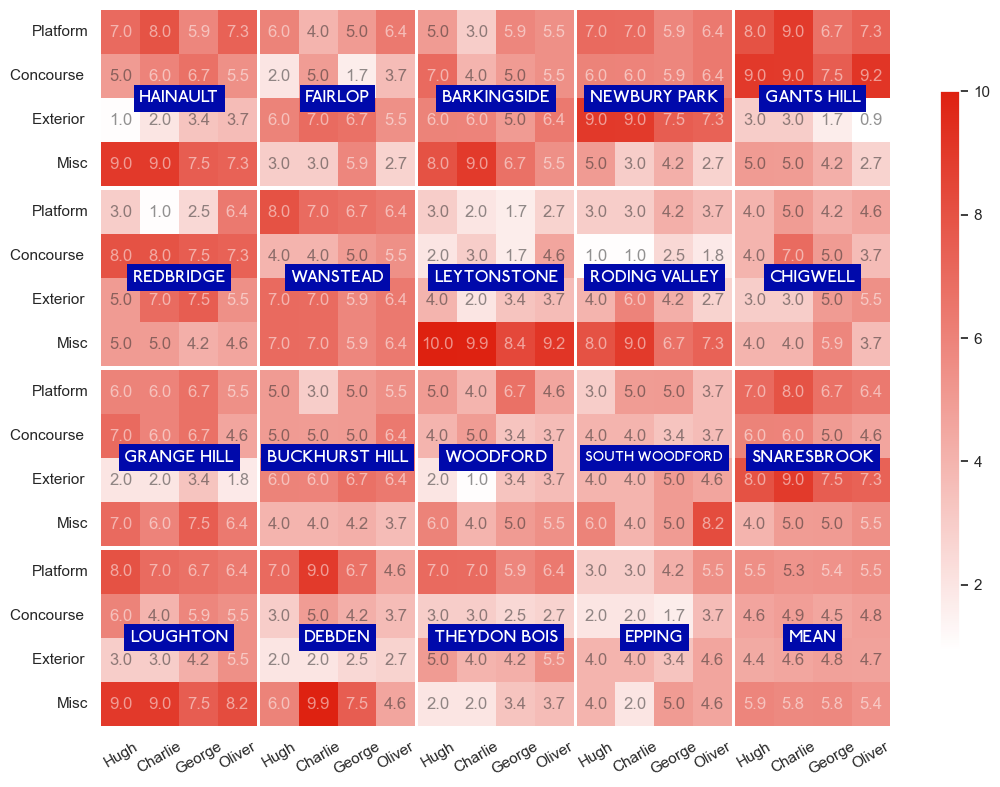

In [6]:
df_total = pd.concat(
    [
        df,
        df.drop(columns=["Station"])
        .groupby("Detail", sort=False)
        .mean()
        .reset_index()
        .assign(Station="Mean"),
    ],
    ignore_index=True,
)

vmin = df_total.drop(columns=["Station"]).iloc[:, 1:].min().min()
vmax = df_total.drop(columns=["Station"]).iloc[:, 1:].max().max()

# Create the FacetGrid
g = sns.FacetGrid(
    df_total, col="Station", col_wrap=5, despine=False, height=2, aspect=1
)

from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list("custom_white_red", ["white", "#DE2110"])

# Add heatmaps to the FacetGrid
for ax, (name, data) in zip(g.axes.flat, df_total.groupby("Station", sort=False)):
    heatmap_data = data.drop(columns=["Station"]).set_index("Detail")
    sns.heatmap(
        heatmap_data,
        vmin=vmin,
        vmax=vmax,
        ax=ax,
        cmap=cmap,
        cbar=False,
        annot=True,
        fmt=".1f",
    )
    for text in ax.texts:
        text.set_alpha(0.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    ax.set_xlabel("")  # Remove axis labels
    ax.set_ylabel("")  # Remove axis labels
    ax.set_title("")
    ax.text(
        2,
        2,
        name.upper(),  # Title text
        fontsize=12 if name != "South Woodford" else 10,  # Font size
        color="white",  # Text color
        ha="center",  # Horizontal alignment
        va="center",  # Vertical alignment
        fontname="London Tube",
        bbox=dict(facecolor="#0009AB", edgecolor="none"),  # Background
    )

# Remove space between plots
g.fig.subplots_adjust(wspace=0.02, hspace=0.02)

# Add a shared colorbar
g.fig.subplots_adjust(right=0.85)  # Adjust for space for the colorbar
cbar_ax = g.fig.add_axes([0.9, 0.15, 0.02, 0.7])  # Position for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
g.fig.colorbar(sm, cax=cbar_ax)

You can see some interesting things from this plot - wherever there's a "horizontal strip" that indicates a particularly distinctive station feature (e.g. the fantastic concourse at Redbridge) and the "vertical strips" indicate strong personal preferences for stations (e.g. George's love of Grange Hill).

## Personal analysis

The following section explores what the above results tell us about each person.

This uses the un-normalised scores to asses who was most generous with their point-giving. There is a clear winner and loser.

**Award for Most Generous:** 🏆 George 🏆

**Award for Least Generous:** 😑 Hugh 😑

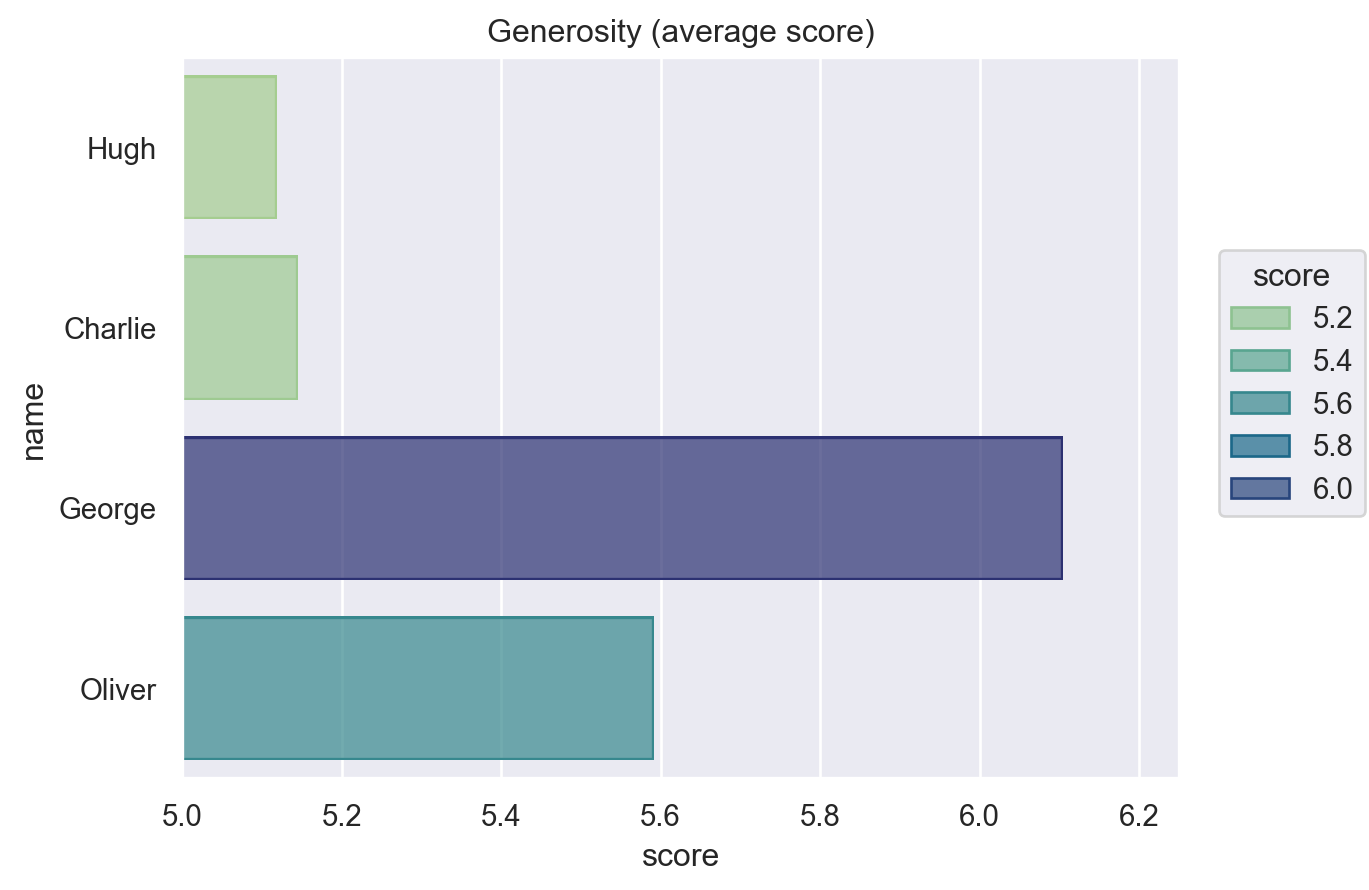

In [7]:
average_person_scores = (
    raw_df[names].mean().reset_index(name="score").rename({"index": "name"}, axis=1)
)
so.Plot(average_person_scores, y="name", x="score", color="score").add(so.Bar()).limit(
    x=(5, 6.25)
).label(title="Generosity (average score)").scale(color="crest")

We can also look at whose scores tended to vary most with respect to the mean, which tells us who was the most erratic among us.

**Award for Most Erratic:** 🏆 Charlie 🏆

**Award for Least Erratic:** 😑 George 😑 (a _very_ close call)

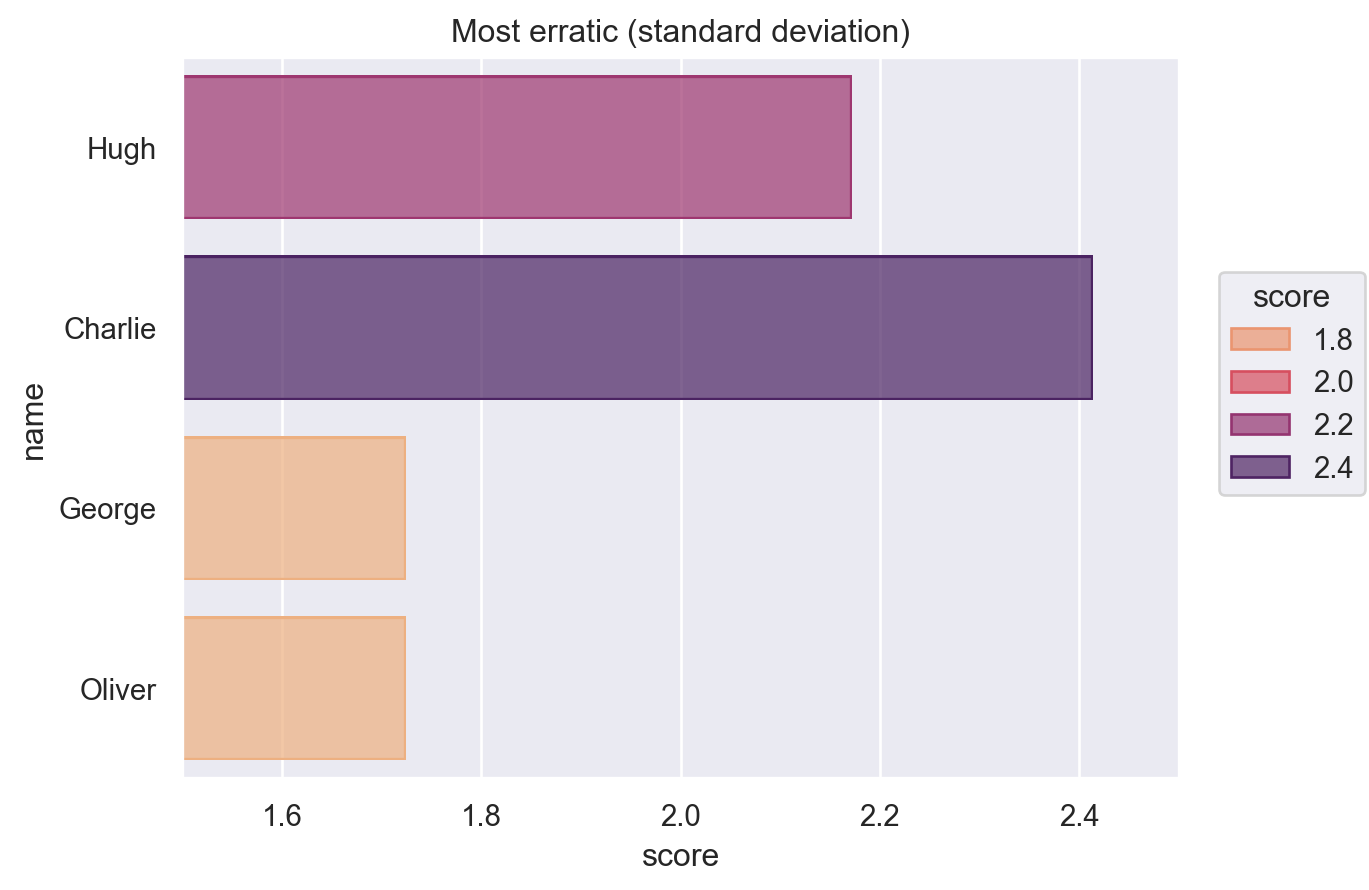

In [8]:
person_variance = (
    df[names].std().reset_index(name="score").rename({"index": "name"}, axis=1)
)
so.Plot(person_variance, y="name", x="score", color="score").add(so.Bar()).limit(
    x=(1.5, 2.5)
).label(title="Most erratic (standard deviation)").scale(color="flare")

In [9]:
detail_means = df.drop(columns="Station").groupby("Detail").mean()
# detail_means

In [10]:
fave_feature_df = detail_means.idxmax().to_frame(name="Favourite Feature")
fave_feature_df.index.name = "Name"
# fave_feature_df

Finally, we'll look at the biggest fans of each feature. Rather neatly, this is a nice one-to-one mapping. Who know George loved exteriors so much, or that Charlie was such a concourse connoisseur? 

In [11]:
most_pref_df = detail_means.transpose().idxmax().to_frame(name="Most preferred by")
most_pref_df.index.name = "Feature"
most_pref_df

,Most preferred by
Feature,
Concourse,Charlie
Exterior,George
Misc,Hugh
Platform,Oliver


## Station Analysis

Now we get to the best bit. Ranking the stations!

We'll start with the _Best Station per Feature_ before moving onto the grand finale of _Overall Best Station_.

The following four plots each display results for a feature (e.g. exterior). The x-axis is ordered by the average score across the four of us, meaning it can be read as the worst-to-best ordering of the stations for that feature.

Take note of everyone's favourite station-features!

In [12]:
mean_df = df.drop(columns="Detail").groupby("Station").mean()
mean_df["Mean"] = mean_df.mean(axis=1)
mean_df = mean_df.sort_values(by="Mean", ascending=True)
mean_df = mean_df.reset_index()
mean_df = mean_df.melt(
    id_vars=["Station"],
    value_vars=["Mean"] + names,
    var_name="Name",
    value_name="Score",
)
# mean_df["Linestyle"] = mean_df["Name"].apply(lambda n: ":" if n == "Mean" else "-")
# mean_df

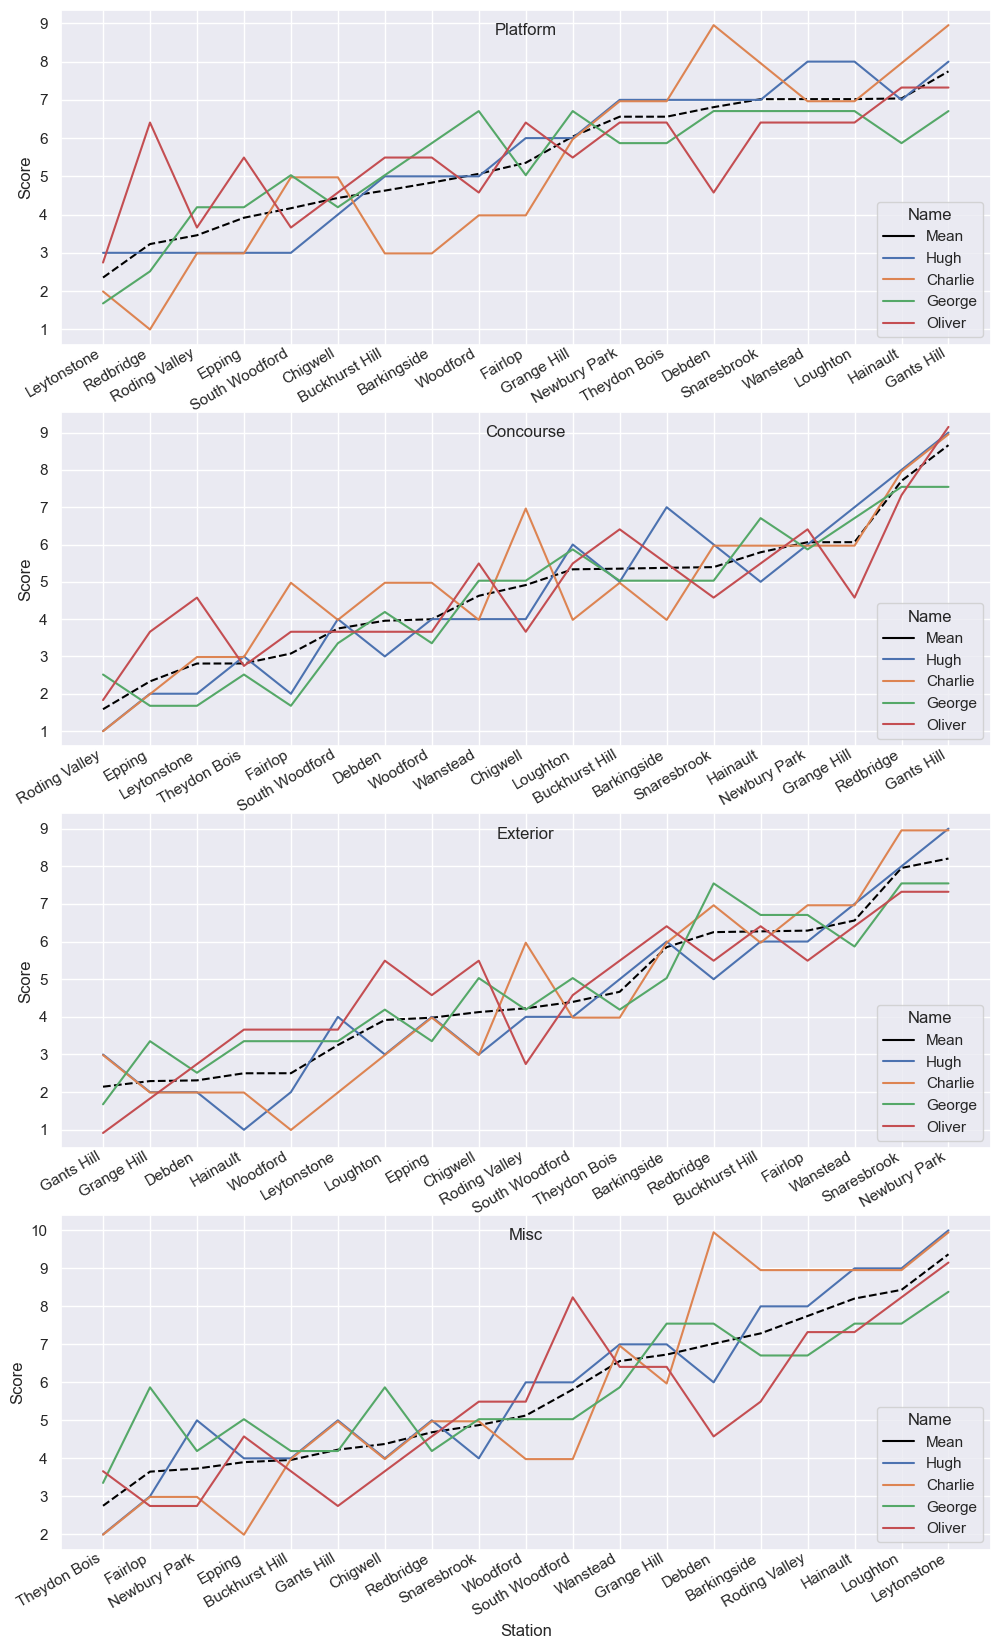

In [13]:
palette = sns.color_palette()
palette = [(0, 0, 0)] + palette
f, axs = plt.subplots(4, 1, figsize=(12, 20))
features_df = df.copy()
features_df["Mean"] = df[names].mean(axis=1)
for feature, ax in zip(features, axs):
    feature_df = (
        features_df[features_df["Detail"].apply(str.strip) == feature]
        .sort_values(by="Mean")
        .reset_index()
        .drop(columns=["Detail"])
        .melt(
            id_vars=["Station"],
            value_vars=["Mean"] + names,
            var_name="Name",
            value_name="Score",
        )
    )
    sns.lineplot(feature_df, x="Station", y="Score", hue="Name", ax=ax, palette=palette)
    sns.move_legend(ax, "lower right")
    ax.lines[0].set_linestyle("--")
    ax.set_title(feature, y=0.9)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
    ax.xaxis.set_tick_params(pad=-5)

Let's give out some more awards based on these results:

**Award for Best Platform:** 🏆 Gants Hill 🏆

![](gants-hill-platform.png)

**Award for Best Concourse:** 🏆 Gants Hill 🏆 (again)

![](gants-hill-concourse.png)

**Award for Best Exterior:** 🏆 Newbury Park 🏆

![](newbury-park-exterior.png)

**Award for Best Misc:** 🏆 Leytonstone 🏆 

![](leytonstone-misc.png)

**Award for Worst Platform:** 😑 Leytonstone 😑

![](leytonstone-platform.png)

**Award for Worst Concourse:** 😑 Roding Valley 😑

![](roding-valley-concourse.png)

**Award for Worst Exterior:** 😑 Gants Hill 😑

![](gants-hill-exterior.png)

**Award for Worst Misc:** 😑 Theydon Bois 😑

![](theydon-misc.png)

And finally ... what you've all been waiting for: Stations ordered by (average) Score!

(interestingly neither the best or worst station are featured in the above awards)

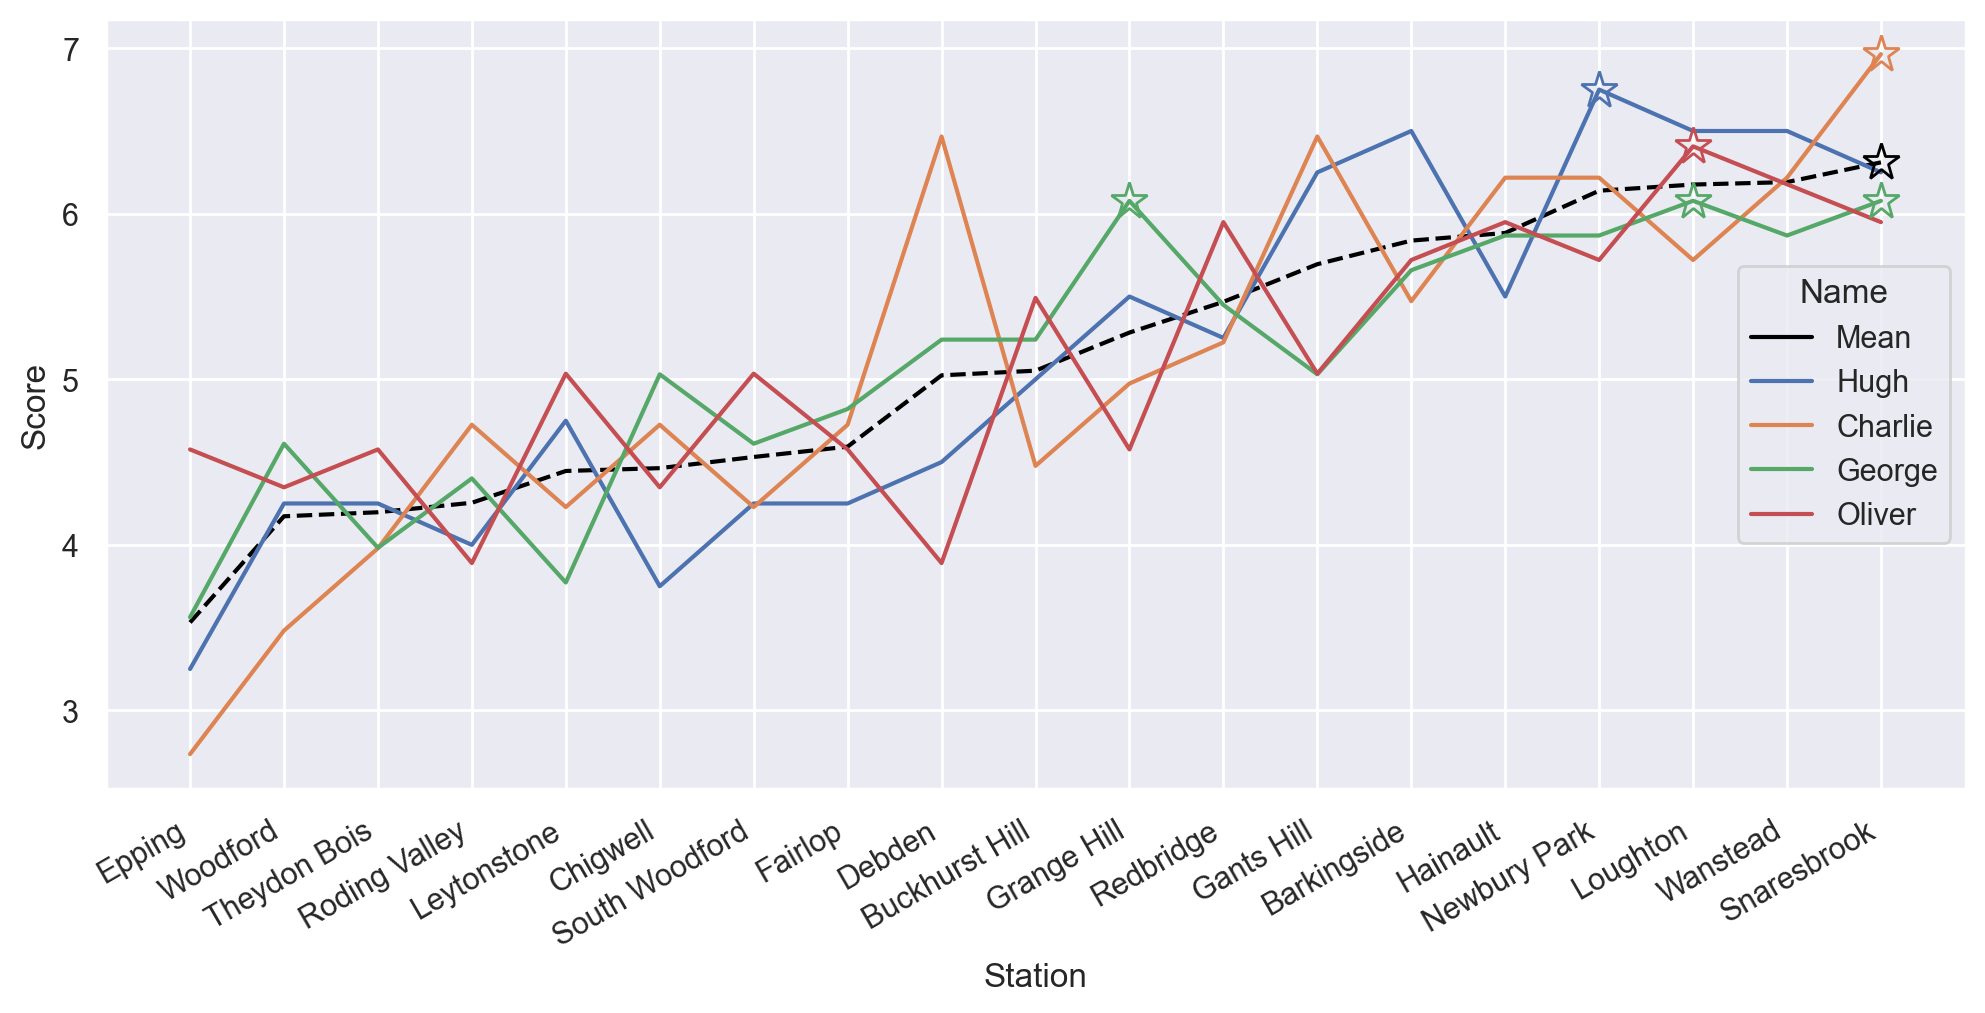

In [14]:
sns.set_theme(rc={"figure.dpi": 200})
f, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(mean_df, x="Station", y="Score", hue="Name", ax=ax, palette=palette)
sns.move_legend(ax, "center right")
ax.lines[0].set_linestyle("--")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
for location, idx in [
    ("Snaresbrook", 0),
    ("Newbury Park", 1),
    ("Snaresbrook", 2),
    ("Loughton", 3),
    ("Snaresbrook", 3),
    ("Grange Hill", 3),
    ("Loughton", 4),
]:
    ax.plot(
        location,
        mean_df[mean_df["Name"] == ("Mean" if idx == 0 else names[idx - 1])][
            "Score"
        ].max(),
        marker="*",
        markersize=14,
        color=palette[idx],
        fillstyle="none",
    )
None

**Award for Best Station:** 🏆 Snaresbrook 🏆 

![](snaresbrook.png)

**Award for Worst Station:** 😑 Epping 😑

![](epping.png)

**Hugh:** Best station =  Newbury Park | Worst station = Epping

**Charlie:** Best station = Snaresbrook | Worst station = Epping

**George:** Best station = Grange Hill / Loughton / Snaresbrook | Worst station = Epping

**Oliver:** Best station = Loughton | Worst station = Roding Valley / Debden